In [1]:
import sys
import os
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import glob
from collections import defaultdict

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'training'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/training


## Configuration

Select the model type and version to analyze.

In [ ]:
# ============================================================================
# MODEL CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Model type: 'clean' (3-channel joint), 'triple' (3 separate VDMs), 'ddpm' (score_models),
#             'interpolant' (flow matching), 'consistency' (consistency models), 'ot_flow' (OT flow matching)
MODEL_TYPE = 'clean'  # Options: 'clean', 'triple', 'ddpm', 'interpolant', 'consistency', 'ot_flow'

# Model names for each type (set the one you want to analyze)
MODEL_NAMES = {
    'clean': 'clean_vdm_aggressive_stellar',
    'triple': 'triple_vdm_separate_models',
    'ddpm': 'ddpm_ncsnpp_vp',
    'interpolant': 'interpolant_3ch',
    'consistency': 'consistency_3ch',
    'ot_flow': 'ot_flow_3ch',
}

# Select model name based on type
MODEL_NAME = MODEL_NAMES[MODEL_TYPE]

# Version number (check available versions below)
VERSION = 0

# TensorBoard logs root
TB_LOGS_ROOT = Path('/mnt/home/mlee1/ceph/tb_logs')

# Build log path
LOG_PATH = TB_LOGS_ROOT / MODEL_NAME / f'version_{VERSION}'
print(f"Model type: {MODEL_TYPE}")
print(f"Model name: {MODEL_NAME}")
print(f"Loading logs from: {LOG_PATH}")

# Verify path exists
if not LOG_PATH.exists():
    print(f"\n❌ Log path does not exist!")
    print(f"Available versions for {MODEL_NAME}:")
    model_dir = TB_LOGS_ROOT / MODEL_NAME
    if model_dir.exists():
        available = list(model_dir.glob('version_*'))
        for v in sorted(available):
            print(f"  - {v.name}")
    else:
        print(f"  (Model directory not found: {model_dir})")
        print(f"\nAvailable models:")
        for d in sorted(TB_LOGS_ROOT.glob('*')):
            if d.is_dir():
                print(f"  - {d.name}")
else:
    print(f"✓ Log path found")

Loading logs from: /mnt/home/mlee1/ceph/tb_logs/triple_vdm_separate_models/version_4
✓ Log path found


## Load TensorBoard Events

In [22]:
def load_tensorboard_logs(log_path):
    """
    Load all scalar metrics from TensorBoard event files.
    
    Returns:
        dict: {metric_name: {'steps': [...], 'values': [...]}}
    """
    event_files = list(Path(log_path).glob('events.out.tfevents.*'))
    if not event_files:
        raise FileNotFoundError(f"No event files found in {log_path}")
    
    print(f"Found {len(event_files)} event file(s)")
    
    metrics = defaultdict(lambda: {'steps': [], 'values': [], 'wall_times': []})
    
    for event_file in event_files:
        ea = event_accumulator.EventAccumulator(
            str(event_file),
            size_guidance={'scalars': 0}  # Load all scalars
        )
        ea.Reload()
        
        for tag in ea.Tags()['scalars']:
            events = ea.Scalars(tag)
            for event in events:
                metrics[tag]['steps'].append(event.step)
                metrics[tag]['values'].append(event.value)
                metrics[tag]['wall_times'].append(event.wall_time)
    
    # Convert to numpy arrays and sort by step
    for tag in metrics:
        sort_idx = np.argsort(metrics[tag]['steps'])
        metrics[tag]['steps'] = np.array(metrics[tag]['steps'])[sort_idx]
        metrics[tag]['values'] = np.array(metrics[tag]['values'])[sort_idx]
        metrics[tag]['wall_times'] = np.array(metrics[tag]['wall_times'])[sort_idx]
    
    return dict(metrics)

# Load the logs
metrics = load_tensorboard_logs(LOG_PATH)
print(f"\nLoaded {len(metrics)} metrics:")
for tag in sorted(metrics.keys()):
    n_points = len(metrics[tag]['steps'])
    print(f"  {tag}: {n_points} points")

Found 1 event file(s)

Loaded 111 metrics:
  epoch: 1576 points
  gradients/max_norm: 4500 points
  gradients/mean_norm: 4500 points
  gradients/std_norm: 4500 points
  gradients/total_norm: 4500 points
  hp_metric: 1 points
  lr-AdamW: 1500 points
  lr-AdamW-1: 1500 points
  lr-AdamW-2: 1500 points
  train/elbo_epoch: 38 points
  train/elbo_step: 1500 points
  train/gas/data_noise_all_epoch: 38 points
  train/gas/data_noise_all_step: 1500 points
  train/gas/diffusion_loss_dm_epoch: 38 points
  train/gas/diffusion_loss_dm_step: 1500 points
  train/gas/diffusion_loss_epoch: 38 points
  train/gas/diffusion_loss_gas_epoch: 38 points
  train/gas/diffusion_loss_gas_step: 1500 points
  train/gas/diffusion_loss_step: 1500 points
  train/gas/elbo_epoch: 38 points
  train/gas/elbo_step: 1500 points
  train/gas/latent_loss_epoch: 38 points
  train/gas/latent_loss_step: 1500 points
  train/gas/mean_gamma_epoch: 38 points
  train/gas/mean_gamma_step: 1500 points
  train/gas/mean_snr_epoch: 38 poin

## Plot Overall Training/Validation Loss

Saved: /mnt/home/mlee1/vdm_BIND/analysis/figures/training/triple_vdm_separate_models_v4_overall_loss.png


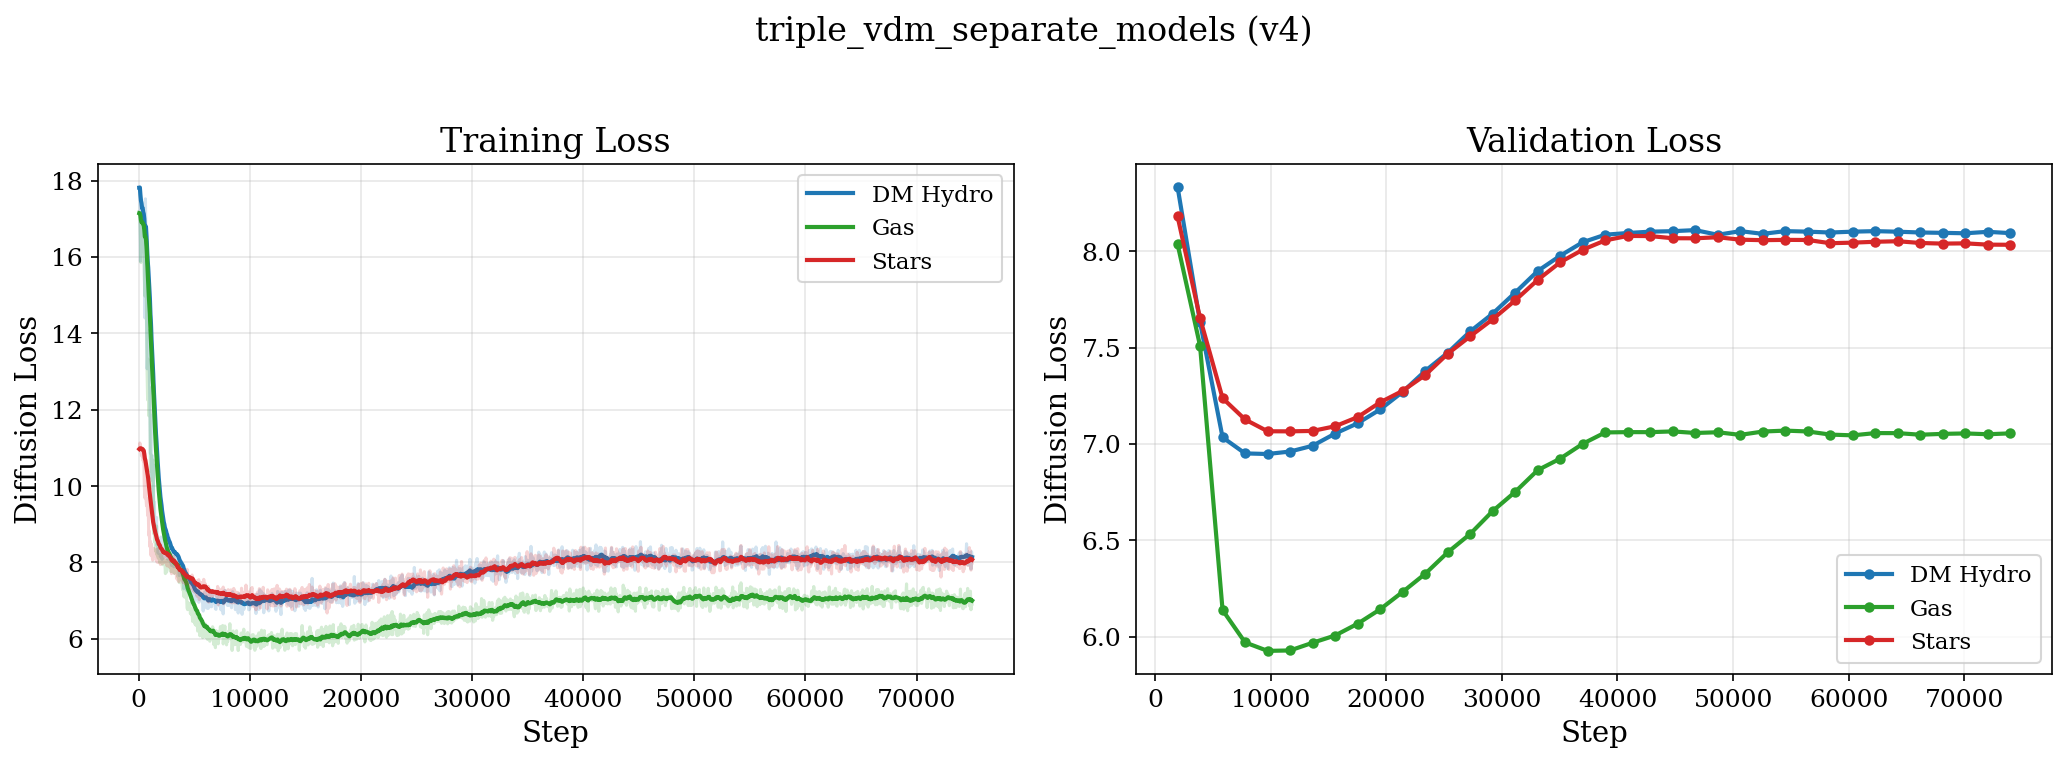

In [ ]:
def smooth_curve(values, weight=0.9):
    """Exponential moving average smoothing."""
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return np.array(smoothed)

# Define metric keys based on model type
if MODEL_TYPE == 'triple':
    # Triple model has separate namespaces for each VDM
    TRIPLE_NAMES = ['hydro_dm', 'gas', 'stars']
    DISPLAY_NAMES = {'hydro_dm': 'DM Hydro', 'gas': 'Gas', 'stars': 'Stars'}
    train_loss_keys = {name: f'train/{name}/diffusion_loss_step' for name in TRIPLE_NAMES}
    val_loss_keys = {name: f'val/{name}/diffusion_loss' for name in TRIPLE_NAMES}
    
elif MODEL_TYPE == 'ddpm':
    # DDPM uses score_models with 'loss' naming
    train_loss_keys = {'combined': 'train/loss_step'}
    val_loss_keys = {'combined': 'val/loss'}
    
elif MODEL_TYPE == 'interpolant':
    # Interpolant uses velocity MSE loss
    train_loss_keys = {'combined': 'train/loss_step'}
    val_loss_keys = {'combined': 'val/loss'}

elif MODEL_TYPE == 'consistency':
    # Consistency model uses consistency training loss
    train_loss_keys = {'combined': 'train/loss_step'}
    val_loss_keys = {'combined': 'val/loss'}

elif MODEL_TYPE == 'ot_flow':
    # OT Flow uses velocity MSE loss (similar to interpolant)
    train_loss_keys = {'combined': 'train/loss_step'}
    val_loss_keys = {'combined': 'val/loss'}
    
else:  # clean
    # Clean VDM model has combined metrics
    train_loss_keys = {'combined': 'train/diffusion_loss_step'}
    val_loss_keys = {'combined': 'val/diffusion_loss'}

# Print available metrics for debugging
print(f"Model type: {MODEL_TYPE}")
print(f"Looking for train keys: {list(train_loss_keys.values())}")
print(f"Looking for val keys: {list(val_loss_keys.values())}")
print(f"\nAvailable metrics containing 'loss':")
for k in sorted(metrics.keys()):
    if 'loss' in k.lower():
        print(f"  {k}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Training loss
ax = axes[0]
if MODEL_TYPE == 'triple':
    colors = {'hydro_dm': '#1f77b4', 'gas': '#2ca02c', 'stars': '#d62728'}
    for name in TRIPLE_NAMES:
        key = train_loss_keys[name]
        if key in metrics:
            steps = metrics[key]['steps']
            values = metrics[key]['values']
            ax.plot(steps, values, alpha=0.2, color=colors[name])
            ax.plot(steps, smooth_curve(values), color=colors[name], linewidth=2, label=DISPLAY_NAMES[name])
    ax.legend()
else:
    # Single combined loss (clean, ddpm, interpolant, consistency, ot_flow)
    key = train_loss_keys['combined']
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        ax.plot(steps, values, alpha=0.3, color='blue', label='Raw')
        ax.plot(steps, smooth_curve(values), color='blue', linewidth=2, label='Smoothed')
        ax.legend()
    else:
        print(f"Warning: Training loss key '{key}' not found in metrics")

ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title(f'Training Loss ({MODEL_TYPE})')
ax.grid(True, alpha=0.3)

# Right: Validation loss
ax = axes[1]
if MODEL_TYPE == 'triple':
    for name in TRIPLE_NAMES:
        key = val_loss_keys[name]
        if key in metrics:
            steps = metrics[key]['steps']
            values = metrics[key]['values']
            ax.plot(steps, values, 'o-', color=colors[name], markersize=4, linewidth=2, label=DISPLAY_NAMES[name])
    ax.legend()
else:
    key = val_loss_keys['combined']
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        ax.plot(steps, values, 'o-', color='orange', markersize=4, linewidth=2, label='Validation')
        ax.legend()
    else:
        print(f"Warning: Validation loss key '{key}' not found in metrics")

ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title(f'Validation Loss ({MODEL_TYPE})')
ax.grid(True, alpha=0.3)

plt.suptitle(f'{MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
plt.tight_layout()

fig.savefig(FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_overall_loss.png')
plt.show()

## Plot Per-Channel Losses

Visualize the loss contribution from each output channel (DM Hydro, Gas, Stars).

In [29]:
# Find per-channel/per-model loss metrics
channel_names = ['DM Hydro', 'Gas', 'Stars']
channel_colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

channel_metrics_train = {}
channel_metrics_val = {}

if MODEL_TYPE == 'triple':
    # Triple model: each model has its own namespace
    triple_map = {'DM Hydro': 'hydro_dm', 'Gas': 'gas', 'Stars': 'stars'}
    
    for display_name, model_name in triple_map.items():
        train_key = f'train/{model_name}/diffusion_loss_step'
        val_key = f'val/{model_name}/diffusion_loss'
        
        if train_key in metrics:
            channel_metrics_train[display_name] = metrics[train_key]
            print(f"Found {display_name} train loss: {train_key}")
        if val_key in metrics:
            channel_metrics_val[display_name] = metrics[val_key]
            print(f"Found {display_name} val loss: {val_key}")
else:
    # Clean model: per-channel metrics in single namespace
    train_keys = {
        'DM Hydro': 'train/diffusion_loss_dm_step',
        'Gas': 'train/diffusion_loss_gas_step', 
        'Stars': 'train/diffusion_loss_stars_step',
    }
    val_keys = {
        'DM Hydro': 'val/diffusion_loss_dm',
        'Gas': 'val/diffusion_loss_gas',
        'Stars': 'val/diffusion_loss_stars',
    }
    
    for name in channel_names:
        if train_keys[name] in metrics:
            channel_metrics_train[name] = metrics[train_keys[name]]
            print(f"Found {name} train loss: {train_keys[name]}")
        if val_keys[name] in metrics:
            channel_metrics_val[name] = metrics[val_keys[name]]
            print(f"Found {name} val loss: {val_keys[name]}")

Found DM Hydro train loss: train/hydro_dm/diffusion_loss_step
Found DM Hydro val loss: val/hydro_dm/diffusion_loss
Found Gas train loss: train/gas/diffusion_loss_step
Found Gas val loss: val/gas/diffusion_loss
Found Stars train loss: train/stars/diffusion_loss_step
Found Stars val loss: val/stars/diffusion_loss


NameError: name 'per_channel_train' is not defined

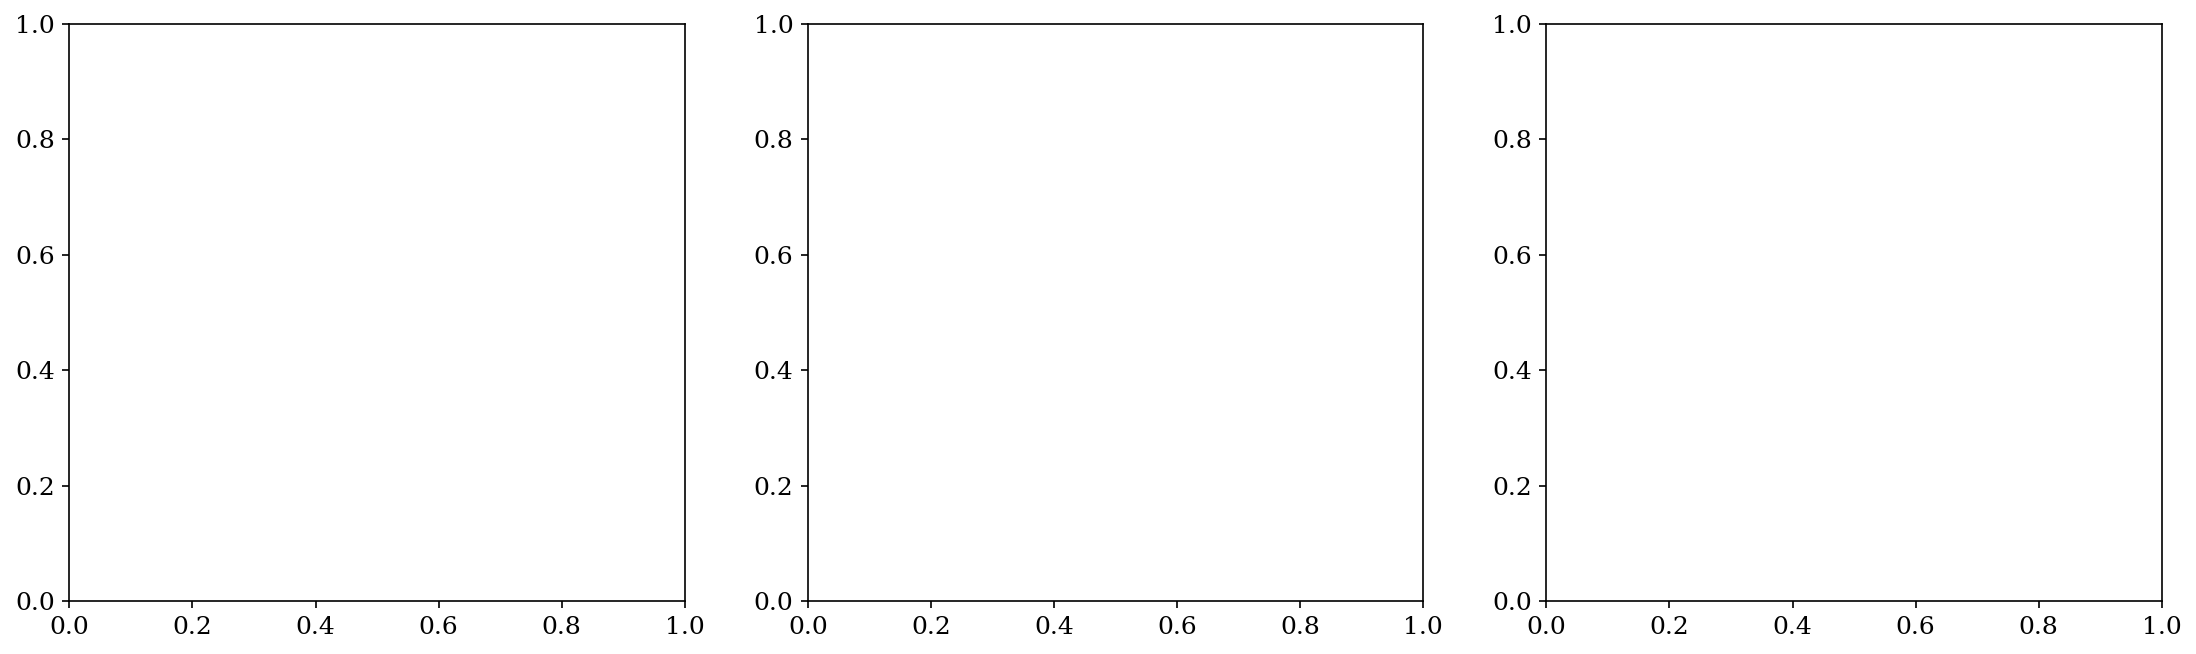

In [30]:
# Per-channel plot with correct metric keys
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(channel_names):
    ax = axes[i]
    train_data = per_channel_train.get(name)
    val_data = per_channel_val.get(name)
    color = channel_colors[i]
    
    if train_data is not None:
        # Raw data with transparency
        ax.plot(train_data['steps'], train_data['values'], alpha=0.2, color=color, label='_nolegend_')
        # Smoothed curve
        ax.plot(train_data['steps'], smooth_curve(train_data['values']), 
                color=color, linewidth=2, label='Train (smoothed)')
    
    if val_data is not None:
        ax.plot(val_data['steps'], val_data['values'], 'o-', color=color, 
                markersize=6, linewidth=2, alpha=0.7, label='Validation')
    
    ax.set_xlabel('Step')
    ax.set_ylabel('Diffusion Loss')
    ax.set_title(f'{name} Channel')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Per-Channel Diffusion Losses - {MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
plt.tight_layout()

fig.savefig(FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_per_channel_losses.png')
print(f"Saved: {FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_per_channel_losses.png'}")
plt.show()

## Plot VDM Loss Components

VDM has multiple loss terms: diffusion loss, latent loss, and reconstruction loss.

Found 9 training loss components
Found 9 validation loss components
Saved: /mnt/home/mlee1/vdm_BIND/analysis/figures/training/triple_vdm_separate_models_v4_vdm_components.png
Saved: /mnt/home/mlee1/vdm_BIND/analysis/figures/training/triple_vdm_separate_models_v4_vdm_components.png


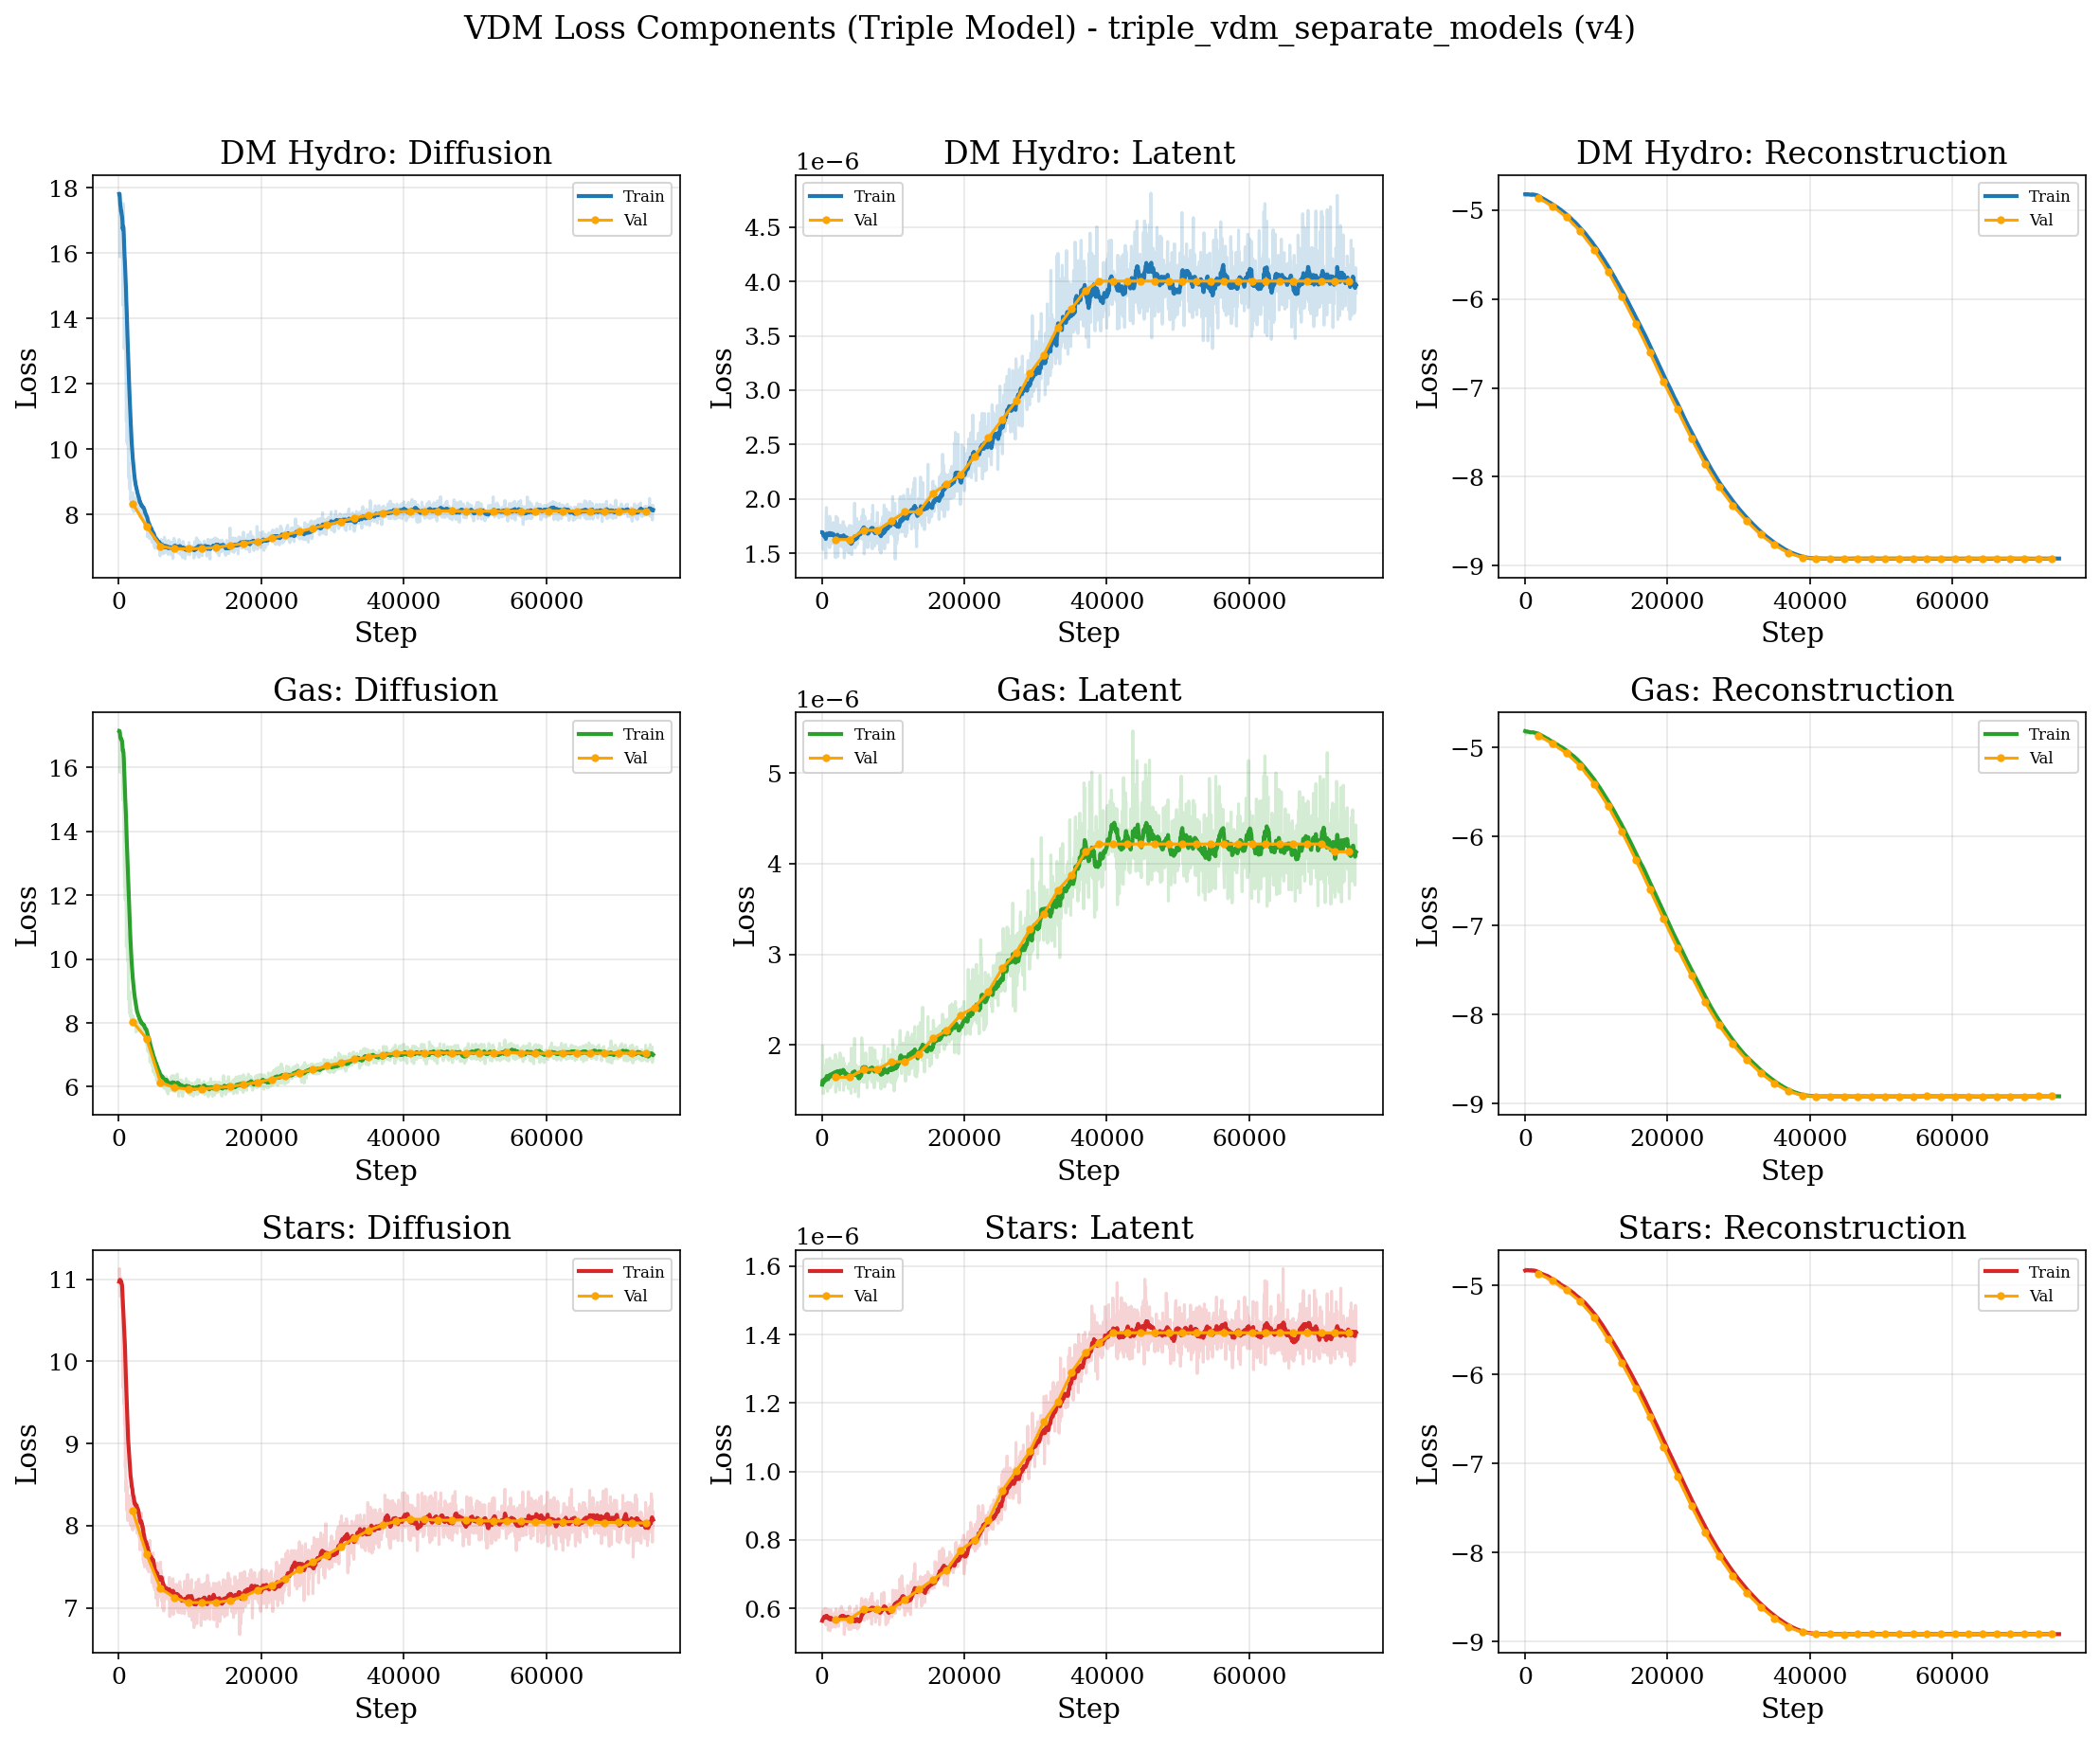

In [31]:
# Find VDM-specific loss components using actual metric names
vdm_losses_train = {}
vdm_losses_val = {}

if MODEL_TYPE == 'triple':
    # For triple model, show components for each separate VDM
    triple_map = {'DM Hydro': 'hydro_dm', 'Gas': 'gas', 'Stars': 'stars'}
    
    # We'll show diffusion, latent, reconstruction for each model
    components = ['diffusion', 'latent', 'reconstruction']
    
    for display_name, model_name in triple_map.items():
        for comp in components:
            key_name = f'{display_name} {comp.title()}'
            if comp == 'diffusion':
                train_key = f'train/{model_name}/diffusion_loss_step'
                val_key = f'val/{model_name}/diffusion_loss'
            elif comp == 'latent':
                train_key = f'train/{model_name}/latent_loss_step'
                val_key = f'val/{model_name}/latent_loss'
            else:
                train_key = f'train/{model_name}/reconstruction_loss_step'
                val_key = f'val/{model_name}/reconstruction_loss'
            
            if train_key in metrics:
                vdm_losses_train[key_name] = metrics[train_key]
            if val_key in metrics:
                vdm_losses_val[key_name] = metrics[val_key]
    
    print(f"Found {len(vdm_losses_train)} training loss components")
    print(f"Found {len(vdm_losses_val)} validation loss components")
else:
    # Clean model: standard VDM components
    train_component_keys = {
        'Diffusion': 'train/diffusion_loss_step',
        'Latent': 'train/latent_loss_step',
        'Reconstruction': 'train/reconstruction_loss_step',
        'Param': 'train/param_loss_step',
    }
    val_component_keys = {
        'Diffusion': 'val/diffusion_loss',
        'Latent': 'val/latent_loss',
        'Reconstruction': 'val/reconstruction_loss',
        'Param': 'val/param_loss',
    }
    
    for name, key in train_component_keys.items():
        if key in metrics:
            vdm_losses_train[name] = metrics[key]
            print(f"Found train {name}: {key}")
    
    for name, key in val_component_keys.items():
        if key in metrics:
            vdm_losses_val[name] = metrics[key]
            print(f"Found val {name}: {key}")

# Plot VDM loss components
if vdm_losses_train:
    if MODEL_TYPE == 'triple':
        # For triple model: 3 rows (one per model), 3 cols (diffusion, latent, recons)
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        
        model_colors = {'DM Hydro': '#1f77b4', 'Gas': '#2ca02c', 'Stars': '#d62728'}
        components = ['Diffusion', 'Latent', 'Reconstruction']
        models = ['DM Hydro', 'Gas', 'Stars']
        
        for row, model in enumerate(models):
            for col, comp in enumerate(components):
                ax = axes[row, col]
                key_name = f'{model} {comp}'
                color = model_colors[model]
                
                if key_name in vdm_losses_train:
                    data = vdm_losses_train[key_name]
                    ax.plot(data['steps'], data['values'], alpha=0.2, color=color)
                    ax.plot(data['steps'], smooth_curve(data['values']), color=color, linewidth=2, label='Train')
                
                if key_name in vdm_losses_val:
                    data = vdm_losses_val[key_name]
                    ax.plot(data['steps'], data['values'], 'o-', color='orange', markersize=3, label='Val')
                
                ax.set_xlabel('Step')
                ax.set_ylabel('Loss')
                ax.set_title(f'{model}: {comp}')
                ax.legend(fontsize=8)
                ax.grid(True, alpha=0.3)
        
        plt.suptitle(f'VDM Loss Components (Triple Model) - {MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
    else:
        # Clean model: original layout
        n_losses = len(vdm_losses_train)
        fig, axes = plt.subplots(2, n_losses, figsize=(4*n_losses, 8))
        
        colors = {'Diffusion': '#1f77b4', 'Latent': '#ff7f0e', 
                  'Reconstruction': '#2ca02c', 'Param': '#d62728'}
        
        for i, (name, data) in enumerate(vdm_losses_train.items()):
            ax = axes[0, i] if n_losses > 1 else axes[0]
            color = colors.get(name, 'gray')
            ax.plot(data['steps'], data['values'], alpha=0.2, color=color)
            ax.plot(data['steps'], smooth_curve(data['values']), color=color, linewidth=2)
            ax.set_xlabel('Step')
            ax.set_ylabel('Loss')
            ax.set_title(f'Train: {name}')
            ax.grid(True, alpha=0.3)
        
        for i, name in enumerate(vdm_losses_train.keys()):
            ax = axes[1, i] if n_losses > 1 else axes[1]
            if name in vdm_losses_val:
                data = vdm_losses_val[name]
                color = colors.get(name, 'gray')
                ax.plot(data['steps'], data['values'], 'o-', color=color, markersize=4, linewidth=2)
            ax.set_xlabel('Step')
            ax.set_ylabel('Loss')
            ax.set_title(f'Val: {name}')
            ax.grid(True, alpha=0.3)
        
        plt.suptitle(f'VDM Loss Components - {MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
    
    plt.tight_layout()
    fig.savefig(FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_vdm_components.png')
    print(f"Saved: {FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_vdm_components.png'}")
    plt.show()
else:
    print("No VDM-specific loss components found.")

## Reconstruction Loss Per Channel

The reconstruction loss shows how well the model reconstructs each channel at the final denoising step.

Saved: /mnt/home/mlee1/vdm_BIND/analysis/figures/training/triple_vdm_separate_models_v4_reconstruction_losses.png


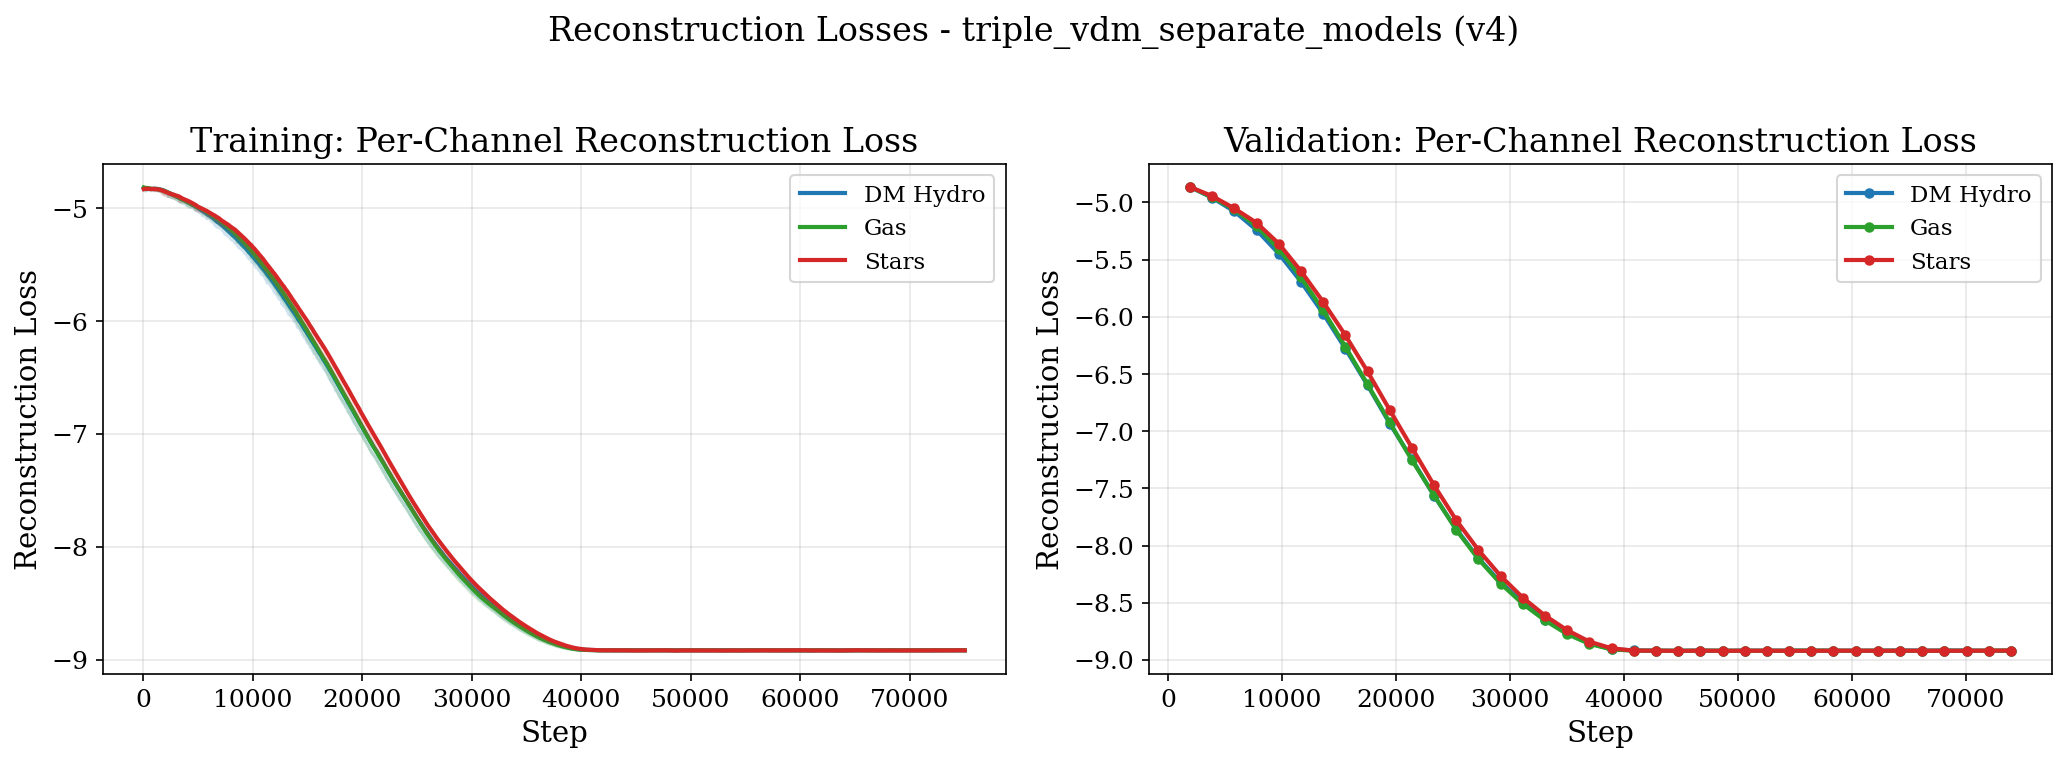

In [32]:
# Plot reconstruction loss per channel/model
recons_train = {}
recons_val = {}

if MODEL_TYPE == 'triple':
    triple_map = {'DM Hydro': 'hydro_dm', 'Gas': 'gas', 'Stars': 'stars'}
    for display_name, model_name in triple_map.items():
        train_key = f'train/{model_name}/reconstruction_loss_step'
        val_key = f'val/{model_name}/reconstruction_loss'
        if train_key in metrics:
            recons_train[display_name] = metrics[train_key]
        if val_key in metrics:
            recons_val[display_name] = metrics[val_key]
else:
    train_recons_keys = {
        'DM Hydro': 'train/recons_loss_dm_step',
        'Gas': 'train/recons_loss_gas_step',
        'Stars': 'train/recons_loss_stars_step',
    }
    val_recons_keys = {
        'DM Hydro': 'val/recons_loss_dm',
        'Gas': 'val/recons_loss_gas',
        'Stars': 'val/recons_loss_stars',
    }
    for name in channel_names:
        if train_recons_keys[name] in metrics:
            recons_train[name] = metrics[train_recons_keys[name]]
        if val_recons_keys[name] in metrics:
            recons_val[name] = metrics[val_recons_keys[name]]

if recons_train or recons_val:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Training reconstruction loss
    ax = axes[0]
    for i, name in enumerate(channel_names):
        if name in recons_train:
            data = recons_train[name]
            color = channel_colors[i]
            ax.plot(data['steps'], data['values'], alpha=0.2, color=color)
            ax.plot(data['steps'], smooth_curve(data['values']), color=color, linewidth=2, label=name)
    ax.set_xlabel('Step')
    ax.set_ylabel('Reconstruction Loss')
    ax.set_title('Training: Per-Channel Reconstruction Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Right: Validation reconstruction loss
    ax = axes[1]
    for i, name in enumerate(channel_names):
        if name in recons_val:
            data = recons_val[name]
            color = channel_colors[i]
            ax.plot(data['steps'], data['values'], 'o-', color=color, markersize=4, linewidth=2, label=name)
    ax.set_xlabel('Step')
    ax.set_ylabel('Reconstruction Loss')
    ax.set_title('Validation: Per-Channel Reconstruction Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Reconstruction Losses - {MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
    plt.tight_layout()
    
    fig.savefig(FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_reconstruction_losses.png')
    print(f"Saved: {FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_reconstruction_losses.png'}")
    plt.show()
else:
    print("No reconstruction loss metrics found.")

## Noise Schedule Diagnostics

Monitor the learned noise schedule via SNR (signal-to-noise ratio) and gamma values.

Saved: /mnt/home/mlee1/vdm_BIND/analysis/figures/training/triple_vdm_separate_models_v4_diagnostics.png


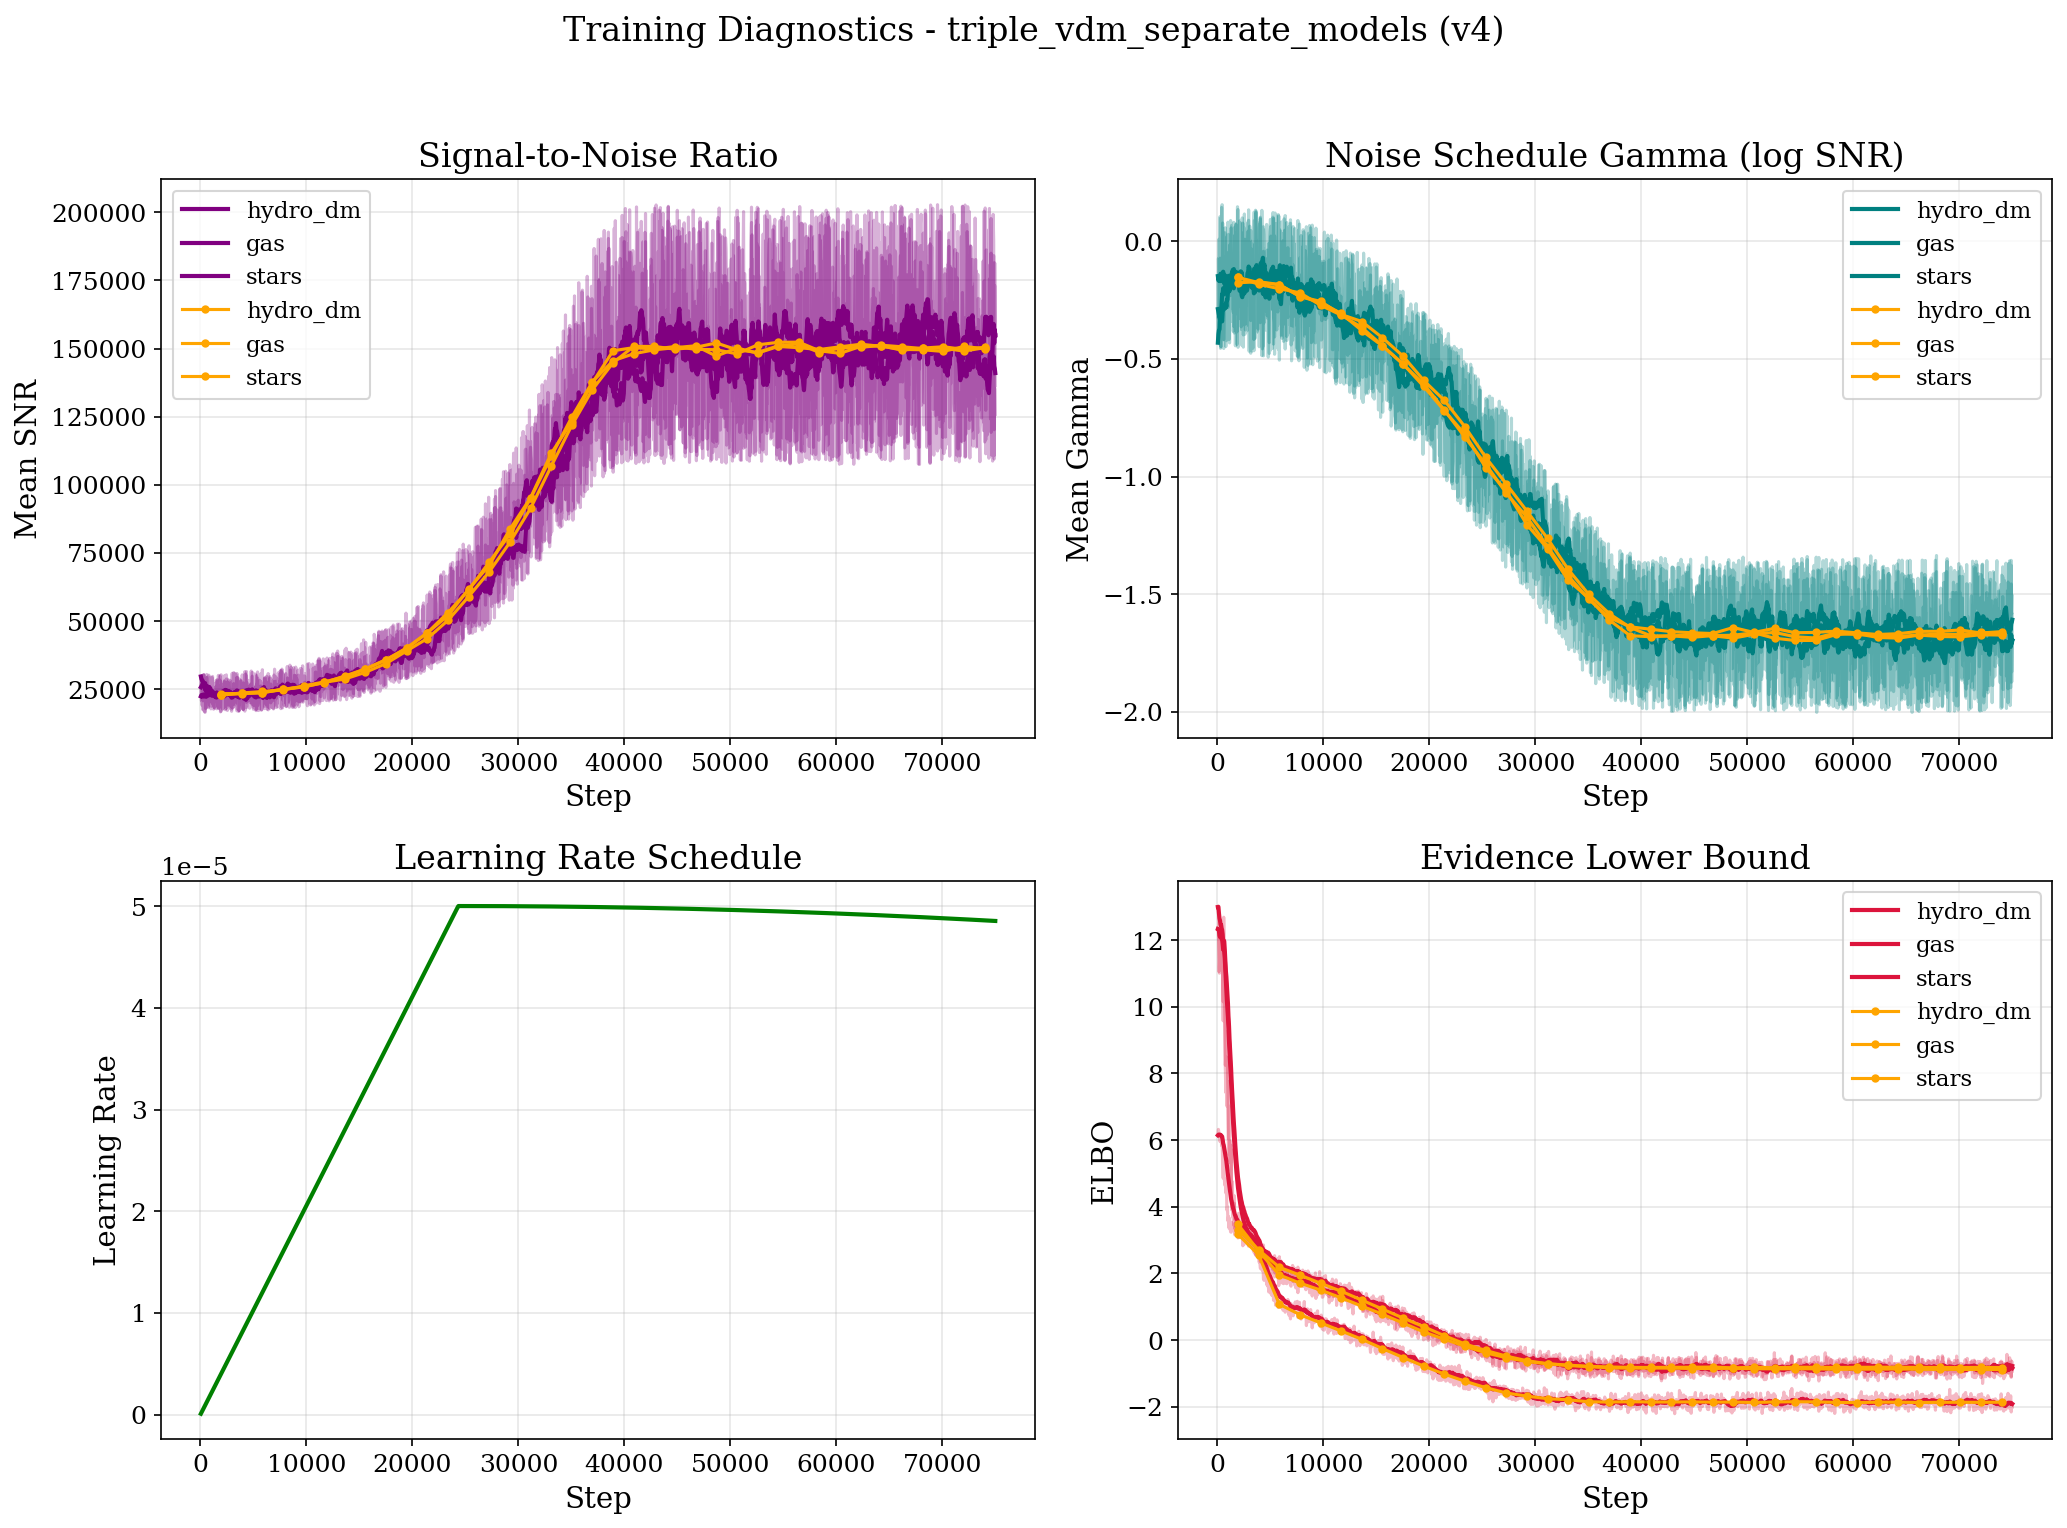

In [33]:
# Plot noise schedule diagnostics: SNR and Gamma
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# For triple model, aggregate SNR/gamma from components
if MODEL_TYPE == 'triple':
    # SNR - try each component and use the first one found
    snr_train_keys = [f'train/{c}/mean_snr_step' for c in ['hydro_dm', 'gas', 'stars']]
    snr_val_keys = [f'val/{c}/mean_snr' for c in ['hydro_dm', 'gas', 'stars']]
    gamma_train_keys = [f'train/{c}/mean_gamma_step' for c in ['hydro_dm', 'gas', 'stars']]
    gamma_val_keys = [f'val/{c}/mean_gamma' for c in ['hydro_dm', 'gas', 'stars']]
    elbo_train_keys = [f'train/{c}/elbo_step' for c in ['hydro_dm', 'gas', 'stars']]
    elbo_val_keys = [f'val/{c}/elbo' for c in ['hydro_dm', 'gas', 'stars']]
else:
    snr_train_keys = ['train/mean_snr_step']
    snr_val_keys = ['val/mean_snr']
    gamma_train_keys = ['train/mean_gamma_step']
    gamma_val_keys = ['val/mean_gamma']
    elbo_train_keys = ['train/elbo_step']
    elbo_val_keys = ['val/elbo']

# Top-left: Mean SNR over training
ax = axes[0, 0]
for key in snr_train_keys:
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        label = key.split('/')[1] if MODEL_TYPE == 'triple' else 'Train'
        ax.plot(steps, values, alpha=0.3, color='purple')
        ax.plot(steps, smooth_curve(values), color='purple', linewidth=2, label=label)
        if MODEL_TYPE != 'triple':
            break  # Only plot once for clean model
for key in snr_val_keys:
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        label = key.split('/')[1] if MODEL_TYPE == 'triple' else 'Val'
        ax.plot(steps, values, 'o-', color='orange', markersize=3, label=label)
        if MODEL_TYPE != 'triple':
            break
ax.set_xlabel('Step')
ax.set_ylabel('Mean SNR')
ax.set_title('Signal-to-Noise Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# Top-right: Mean Gamma over training
ax = axes[0, 1]
for key in gamma_train_keys:
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        label = key.split('/')[1] if MODEL_TYPE == 'triple' else 'Train'
        ax.plot(steps, values, alpha=0.3, color='teal')
        ax.plot(steps, smooth_curve(values), color='teal', linewidth=2, label=label)
        if MODEL_TYPE != 'triple':
            break
for key in gamma_val_keys:
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        label = key.split('/')[1] if MODEL_TYPE == 'triple' else 'Val'
        ax.plot(steps, values, 'o-', color='orange', markersize=3, label=label)
        if MODEL_TYPE != 'triple':
            break
ax.set_xlabel('Step')
ax.set_ylabel('Mean Gamma')
ax.set_title('Noise Schedule Gamma (log SNR)')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom-left: Learning rate
ax = axes[1, 0]
if 'lr-AdamW' in metrics:
    steps = metrics['lr-AdamW']['steps']
    values = metrics['lr-AdamW']['values']
    ax.plot(steps, values, color='green', linewidth=2)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule')
ax.grid(True, alpha=0.3)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Bottom-right: ELBO
ax = axes[1, 1]
for key in elbo_train_keys:
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        label = key.split('/')[1] if MODEL_TYPE == 'triple' else 'Train'
        ax.plot(steps, values, alpha=0.3, color='crimson')
        ax.plot(steps, smooth_curve(values), color='crimson', linewidth=2, label=label)
        if MODEL_TYPE != 'triple':
            break
for key in elbo_val_keys:
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        label = key.split('/')[1] if MODEL_TYPE == 'triple' else 'Val'
        ax.plot(steps, values, 'o-', color='orange', markersize=3, label=label)
        if MODEL_TYPE != 'triple':
            break
ax.set_xlabel('Step')
ax.set_ylabel('ELBO')
ax.set_title('Evidence Lower Bound')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'Training Diagnostics - {MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
plt.tight_layout()

fig.savefig(FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_diagnostics.png')
print(f"Saved: {FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_diagnostics.png'}")
plt.show()

## Gradient Statistics

Monitor gradient norms to check for training stability.

Saved: /mnt/home/mlee1/vdm_BIND/analysis/figures/training/clean_vdm_aggressive_stellar_v3_gradients.png


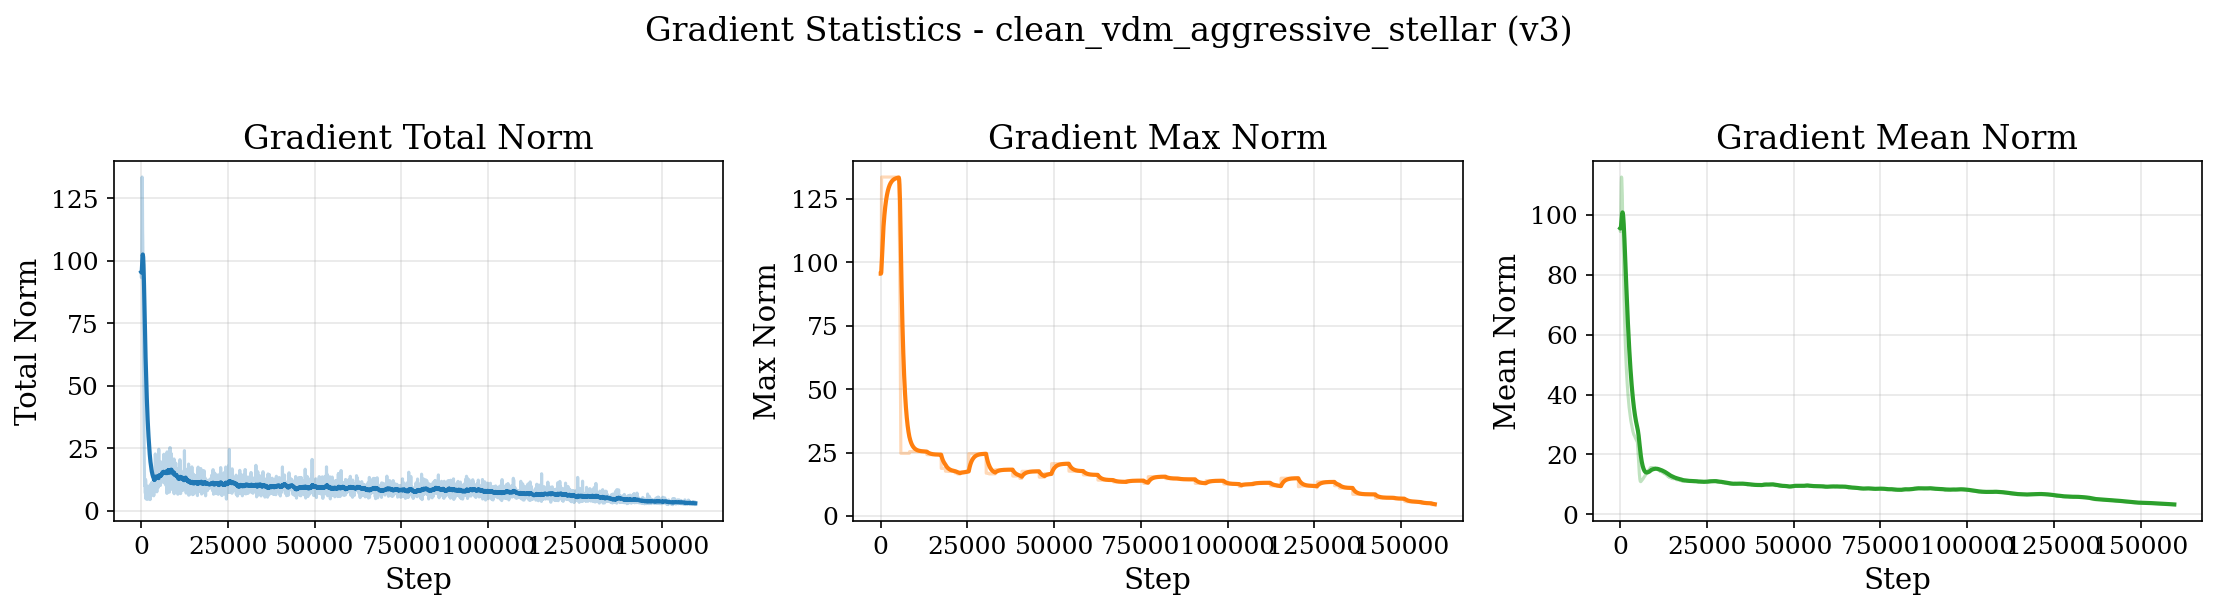

In [ ]:
# Plot gradient statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

gradient_metrics = {
    'Total Norm': 'gradients/total_norm',
    'Max Norm': 'gradients/max_norm',
    'Mean Norm': 'gradients/mean_norm',
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for ax, (name, key), color in zip(axes, gradient_metrics.items(), colors):
    if key in metrics:
        steps = metrics[key]['steps']
        values = metrics[key]['values']
        ax.plot(steps, values, alpha=0.3, color=color)
        ax.plot(steps, smooth_curve(values, weight=0.95), color=color, linewidth=2)
    ax.set_xlabel('Step')
    ax.set_ylabel(name)
    ax.set_title(f'Gradient {name}')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Gradient Statistics - {MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
plt.tight_layout()

fig.savefig(FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_gradients.png')
print(f"Saved: {FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_gradients.png'}")
plt.show()

## Learned Data Noise Per Channel

The per-channel data noise (sigma) learned during training.

Saved: /mnt/home/mlee1/vdm_BIND/analysis/figures/training/clean_vdm_aggressive_stellar_v3_data_noise.png


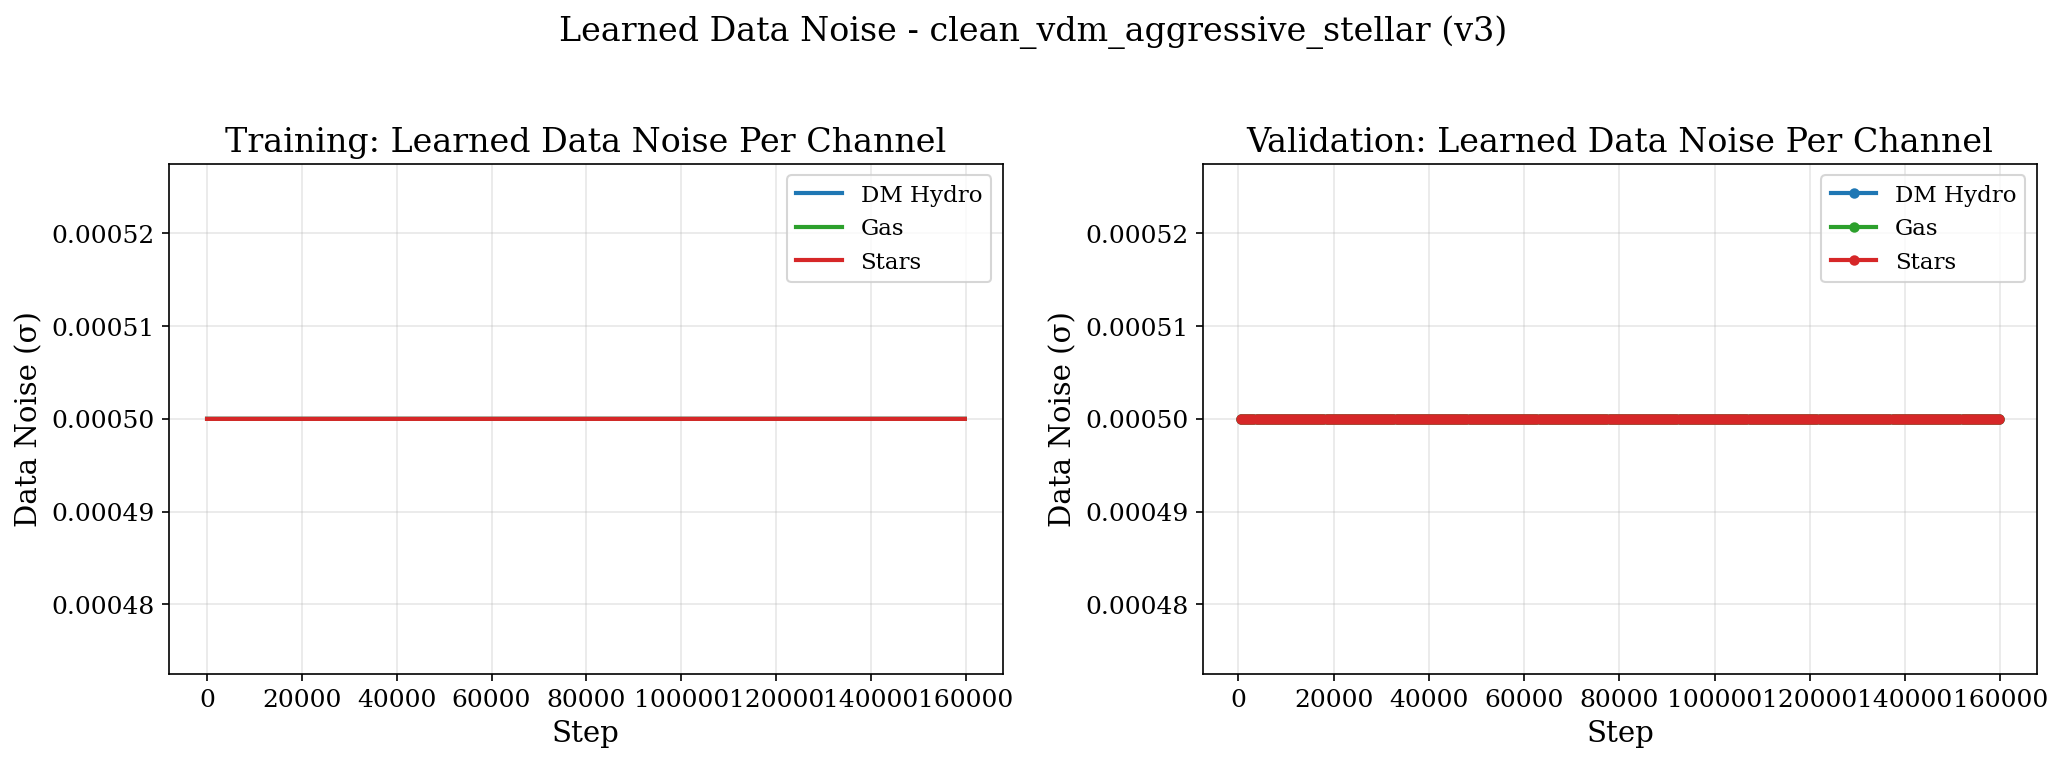

In [17]:
# Plot learned data noise per channel
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if MODEL_TYPE == 'triple':
    triple_map = {'DM Hydro': 'hydro_dm', 'Gas': 'gas', 'Stars': 'stars'}
    train_noise_keys = {name: f'train/{model}/data_noise_step' for name, model in triple_map.items()}
    val_noise_keys = {name: f'val/{model}/data_noise' for name, model in triple_map.items()}
else:
    train_noise_keys = {
        'DM Hydro': 'train/data_noise_dm_step',
        'Gas': 'train/data_noise_gas_step',
        'Stars': 'train/data_noise_stars_step',
    }
    val_noise_keys = {
        'DM Hydro': 'val/data_noise_dm',
        'Gas': 'val/data_noise_gas',
        'Stars': 'val/data_noise_stars',
    }

# Check if we have any data noise metrics
has_train_noise = any(key in metrics for key in train_noise_keys.values())
has_val_noise = any(key in metrics for key in val_noise_keys.values())

if has_train_noise or has_val_noise:
    # Left: Training data noise
    ax = axes[0]
    for i, name in enumerate(channel_names):
        key = train_noise_keys[name]
        if key in metrics:
            steps = metrics[key]['steps']
            values = metrics[key]['values']
            color = channel_colors[i]
            ax.plot(steps, values, alpha=0.3, color=color)
            ax.plot(steps, smooth_curve(values), color=color, linewidth=2, label=name)
    ax.set_xlabel('Step')
    ax.set_ylabel('Data Noise (σ)')
    ax.set_title('Training: Learned Data Noise Per Channel')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Right: Validation data noise
    ax = axes[1]
    for i, name in enumerate(channel_names):
        key = val_noise_keys[name]
        if key in metrics:
            steps = metrics[key]['steps']
            values = metrics[key]['values']
            color = channel_colors[i]
            ax.plot(steps, values, 'o-', color=color, markersize=4, linewidth=2, label=name)
    ax.set_xlabel('Step')
    ax.set_ylabel('Data Noise (σ)')
    ax.set_title('Validation: Learned Data Noise Per Channel')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'Learned Data Noise - {MODEL_NAME} (v{VERSION})', fontsize=16, y=1.02)
    plt.tight_layout()

    fig.savefig(FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_data_noise.png')
    print(f"Saved: {FIGURE_DIR / f'{MODEL_NAME}_v{VERSION}_data_noise.png'}")
    plt.show()
else:
    plt.close(fig)
    print("No data noise metrics found - model may not use learned data noise.")

## Compare Multiple Model Versions (Optional)

Compare loss curves across different model versions or architectures.

In [ ]:
# ============================================================================
# MODEL COMPARISON CONFIGURATION
# ============================================================================

COMPARE_MODELS = True  # Set to True to enable comparison

# Models to compare: list of (model_name, version, label, color)
# All 6 model types are supported!
MODELS_TO_COMPARE = [
    ('clean_vdm_aggressive_stellar', 0, 'VDM Clean', '#1f77b4'),
    ('triple_vdm_separate_models', 0, 'VDM Triple', '#2ca02c'),
    ('ddpm_ncsnpp_vp', 0, 'DDPM NCSNpp', '#d62728'),
    ('interpolant_3ch', 0, 'Interpolant', '#9467bd'),
    ('consistency_3ch', 0, 'Consistency', '#ff7f0e'),
    ('ot_flow_3ch', 0, 'OT Flow', '#17becf'),
]

if COMPARE_MODELS and len(MODELS_TO_COMPARE) > 1:
    print("Loading metrics for model comparison...")
    
    comparison_data = {}
    for model_name, version, label, color in MODELS_TO_COMPARE:
        log_path = TB_LOGS_ROOT / model_name / f'version_{version}'
        if log_path.exists():
            try:
                comparison_data[label] = {
                    'metrics': load_tensorboard_logs(log_path),
                    'color': color
                }
                print(f"  ✓ Loaded {label}")
            except Exception as e:
                print(f"  ✗ Failed to load {label}: {e}")
        else:
            print(f"  ✗ Path not found: {log_path}")
else:
    print("Model comparison disabled or only one model specified.")

Model comparison disabled or only one model specified.


In [19]:
if COMPARE_MODELS and len(MODELS_TO_COMPARE) > 1 and comparison_data:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Training loss comparison
    ax = axes[0]
    for label, data in comparison_data.items():
        if 'train/loss' in data['metrics']:
            steps = data['metrics']['train/loss']['steps']
            values = data['metrics']['train/loss']['values']
            ax.plot(steps, smooth_curve(values), color=data['color'], 
                   linewidth=2, label=label)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Validation loss comparison
    ax = axes[1]
    for label, data in comparison_data.items():
        val_key = 'val/loss' if 'val/loss' in data['metrics'] else 'val/elbo'
        if val_key in data['metrics']:
            steps = data['metrics'][val_key]['steps']
            values = data['metrics'][val_key]['values']
            ax.plot(steps, values, 'o-', color=data['color'], 
                   markersize=3, label=label)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Validation Loss Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Model Comparison', fontsize=16, y=1.02)
    plt.tight_layout()
    
    fig.savefig(FIGURE_DIR / 'model_comparison_losses.png')
    print(f"Saved: {FIGURE_DIR / 'model_comparison_losses.png'}")
    plt.show()

## Summary Statistics

In [20]:
print(f"\n{'='*60}")
print(f"Training Summary: {MODEL_NAME} (v{VERSION})")
print(f"Model Type: {MODEL_TYPE}")
print(f"{'='*60}\n")

# Epochs
if 'epoch' in metrics:
    max_epoch = int(metrics['epoch']['values'].max())
    print(f"Epochs Completed: {max_epoch}")
    print()

# Set up metric keys based on model type
if MODEL_TYPE == 'triple':
    components = ['hydro_dm', 'gas', 'stars']
    train_loss_key = f'train/{components[0]}/diffusion_loss_step'  # Use first component
    val_loss_key = f'val/{components[0]}/diffusion_loss'
    per_channel_val_keys = [(name, f'val/{c}/diffusion_loss') 
                            for name, c in zip(['DM Hydro', 'Gas', 'Stars'], components)]
    data_noise_keys = [(name, f'val/{c}/data_noise') 
                       for name, c in zip(['DM Hydro', 'Gas', 'Stars'], components)]
    elbo_key = f'val/{components[0]}/elbo'
else:
    train_loss_key = 'train/diffusion_loss_step'
    val_loss_key = 'val/diffusion_loss'
    per_channel_val_keys = [('DM Hydro', 'val/diffusion_loss_dm'), 
                            ('Gas', 'val/diffusion_loss_gas'),
                            ('Stars', 'val/diffusion_loss_stars')]
    data_noise_keys = [('DM Hydro', 'val/data_noise_dm'), 
                       ('Gas', 'val/data_noise_gas'),
                       ('Stars', 'val/data_noise_stars')]
    elbo_key = 'val/elbo'

# Final training loss
if train_loss_key in metrics:
    final_train = metrics[train_loss_key]['values'][-1]
    min_train = metrics[train_loss_key]['values'].min()
    print(f"Training Diffusion Loss:")
    print(f"  Final: {final_train:.4f}")
    print(f"  Min:   {min_train:.4f}")
    print()

# Final validation loss
if val_loss_key in metrics:
    final_val = metrics[val_loss_key]['values'][-1]
    min_val = metrics[val_loss_key]['values'].min()
    best_step = metrics[val_loss_key]['steps'][np.argmin(metrics[val_loss_key]['values'])]
    print(f"Validation Diffusion Loss:")
    print(f"  Final: {final_val:.4f}")
    print(f"  Best:  {min_val:.4f} (step {best_step})")
    print()

# Per-channel final losses
print("Per-Channel Validation Diffusion Losses (Final):")
for name, key in per_channel_val_keys:
    if key in metrics:
        final = metrics[key]['values'][-1]
        best = metrics[key]['values'].min()
        print(f"  {name}: {final:.4f} (best: {best:.4f})")
print()

# Learned data noise values
print("Learned Data Noise (Final):")
has_noise = False
for name, key in data_noise_keys:
    if key in metrics:
        final = metrics[key]['values'][-1]
        print(f"  {name}: {final:.4f}")
        has_noise = True
if not has_noise:
    print("  (Not available)")
print()

# ELBO
if elbo_key in metrics:
    final_elbo = metrics[elbo_key]['values'][-1]
    best_elbo = metrics[elbo_key]['values'].min()
    print(f"Validation ELBO:")
    print(f"  Final: {final_elbo:.4f}")
    print(f"  Best:  {best_elbo:.4f}")
    print()

# Training time
if train_loss_key in metrics:
    wall_times = metrics[train_loss_key]['wall_times']
    total_time = (wall_times[-1] - wall_times[0]) / 3600  # hours
    total_steps = metrics[train_loss_key]['steps'][-1]
    print(f"Training Time:")
    print(f"  Total: {total_time:.2f} hours")
    print(f"  Steps: {total_steps}")
    print(f"  Rate:  {total_steps/total_time:.1f} steps/hour")


Training Summary: clean_vdm_aggressive_stellar (v3)

Epochs Completed: 249

Training Diffusion Loss:
  Final: 12.3952
  Min:   11.2057

Validation Diffusion Loss:
  Final: 12.3329
  Best:  11.3014 (step 7028)

Per-Channel Validation Diffusion Losses (Final):
  DM Hydro: 2.5719 (best: 2.3447)
  Gas: 2.2085 (best: 1.9747)
  Stars: 2.5175 (best: 2.3272)

Learned Data Noise (Final):
  DM Hydro: 0.0005
  Gas: 0.0005
  Stars: 0.0005

Validation ELBO:
  Final: 3.8917
  Best:  3.8776

Training Time:
  Total: 40.39 hours
  Steps: 159749
  Rate:  3955.4 steps/hour
